# Module 6: Enhanced Sampling I - Umbrella Sampling (US) & PMF Reconstruction

Welcome to Module 6! In Module 5, we encountered the **sampling problem** when trying to calculate the Potential of Mean Force (PMF) for the double-well potential using standard NVT simulation.

This module introduces **Umbrella Sampling (US)**. We will run multiple biased simulations and then use a custom implementation of the **Weighted Histogram Analysis Method (WHAM)** equations to combine the data and reconstruct the true, unbiased PMF, demonstrating how to overcome the sampling barrier.

### Setup: Imports and Functions (from Modules 4 & 5)

Let's import libraries and redefine the necessary functions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings # To handle potential log(0) issues

# Plotting style configuration (optional)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (6,4) # Default figure size
plt.rcParams['lines.linewidth'] = 2

# Assume Boltzmann constant k_B = 1 for simplicity in reduced units
k_B = 1.0
# Define temperature here as it's needed globally for WHAM
temperature = 1.0 # Will be set properly later

# --- Potential/Force Functions ---
def potential_dw(x, a, b):
  """Calculates the potential energy of a double-well potential."""
  return a * x**4 - b * x**2

def force_dw(x, a, b):
  """Calculates the force from a double-well potential."""
  # Corrected from previous version
  return -4 * a * x**3 + 2 * b * x

# --- Bias Potential/Force Functions ---
def potential_bias_us(x, k_us, x0_us):
    """Calculates the harmonic umbrella sampling bias potential energy."""
    return 0.5 * k_us * (x - x0_us)**2

def force_bias_us(x, k_us, x0_us):
  """Calculates the harmonic umbrella sampling bias force."""
  return -k_us * (x - x0_us)

# --- Langevin Integrator (BAOAB) for US ---
def Velocity_verlet_langevin_US(x_curr, v_curr, mass, dt, gamma, target_temp,
                           force_physical_func, force_bias_func,
                           physical_args={}, bias_args={}):
    """
    Performs one step of Langevin dynamics with physical + bias forces.
    (Same as previous version)
    """
    # Calculate total force F = F_physical + F_bias
    f_phys_curr = force_physical_func(x_curr, **physical_args)
    f_bias_curr = force_bias_func(x_curr, **bias_args)
    f_total_curr = f_phys_curr + f_bias_curr
    # Update velocity by half step
    v_half_b = v_curr + (f_total_curr / mass) * (dt / 2.0)
    # Update position by half step
    x_half_a = x_curr + v_half_b * (dt / 2.0)
    # Apply friction and random kick (unchanged)
    c1 = np.exp(-gamma * dt)
    c2 = np.sqrt(k_B * max(0, target_temp) * (1.0 - c1**2) / mass)
    random_kick = np.random.normal(0, 1)
    v_half_o = c1 * v_half_b + c2 * random_kick
    # Update position by second half step
    x_new = x_half_a + v_half_o * (dt / 2.0)
    # Calculate total force at *new* position
    f_phys_new = force_physical_func(x_new, **physical_args)
    f_bias_new = force_bias_func(x_new, **bias_args)
    f_total_new = f_phys_new + f_bias_new
    # Update velocity by second half step
    v_new = v_half_o + (f_total_new / mass) * (dt / 2.0)
    return x_new, v_new

# --- Parameters for Double Well ---
a_dw = 1.0
b_dw = 4.0
minima_pos = np.sqrt(b_dw / (2 * a_dw))
minima_val = potential_dw(minima_pos, a=a_dw, b=b_dw)
barrier_top_val = potential_dw(0, a=a_dw, b=b_dw)
barrier_height = barrier_top_val - minima_val

print("Setup complete. Functions and parameters loaded.")
print(f"Double-well barrier height: {barrier_height:.2f}")

Setup complete. Functions and parameters loaded.
Double-well barrier height: 4.00


## Lesson 1: The Concept of Biasing

The core idea behind many enhanced sampling methods is to modify the potential energy landscape the system experiences during the simulation. We add an artificial **bias potential**, $V_{bias}(q)$, which depends on our chosen collective variable $q$ (in our case, $q=x$).

The total potential energy used to calculate forces in the simulation becomes:
$$ V_{total}(x) = V_{physical}(x) + V_{bias}(x) $$
where $V_{physical}(x)$ is the original double-well potential.

The corresponding total force is:
$$ F_{total}(x) = F_{physical}(x) + F_{bias}(x) $$
where $F_{bias}(x) = -\frac{dV_{bias}}{dx}$.

By carefully choosing $V_{bias}(x)$, we can make high-energy regions (like the barrier top) more favorable to visit, effectively "flattening" the energy landscape locally and encouraging transitions.

Of course, this simulation runs on a *modified* potential. The data we collect (histograms, averages) are *biased*. The crucial second step is to mathematically remove the effect of the bias potential afterwards to recover the properties of the original, unbiased system, such as the true PMF. Umbrella Sampling uses a specific form of bias and a method called WHAM to achieve this.

## Lesson 2: Harmonic Bias Potentials ("Umbrellas")

Umbrella Sampling uses a series of simulations, often called **"windows"**. In each window $i$, a harmonic bias potential is applied, centered at a specific value $x_{0,i}$ along the collective variable $x$.

The bias potential for window $i$ is:
$$ V_{bias, i}(x) = \frac{1}{2} k_{us} (x - x_{0,i})^2 $$
This potential looks like an inverted parabola or an "umbrella" centered at $x_{0,i}$.
* $k_{us}$ is the **spring constant** of the umbrella potential. It determines how strongly the system is restrained near $x_{0,i}$. A stronger spring constant leads to narrower sampling within the window.
* $x_{0,i}$ is the **center** of the harmonic restraint for window $i$.

The corresponding biasing force for window $i$ is:
$$ F_{bias, i}(x) = -\frac{dV_{bias, i}}{dx} = -k_{us} (x - x_{0,i}) $$

By running multiple simulations with windows centered at different $x_{0,i}$ values that span the entire range of interest (from one well, across the barrier, to the other well), we can ensure that all regions are adequately sampled, even the high-energy barrier region. The harmonic potential in each window "holds" the system in a specific area, allowing us to gather statistics there. The key is that the histograms from adjacent windows should overlap significantly.

## Lesson 3: Implementing Umbrella Sampling

### Setting up Umbrella Sampling Windows & Parameters

Define the window centers, spring constant, and simulation parameters. We'll run the simulations now.

In [ ]:
# Umbrella Sampling Parameters
num_windows = 10 # Number of umbrella windows <- change this to check the effets
k_us = 60       # Umbrella spring constant <- change this to check the effets
# for this case best tested one: num_windows = 10 and k_us = 60
window_centers = np.linspace(-2.0, 2.0, num_windows) # Window center positions

print(f"Umbrella window centers (x0): {window_centers}")
print(f"Umbrella spring constant (k_us): {k_us}")

# Simulation parameters per window
mass = 1.0
dt = 0.01
gamma = 1.0
target_temp_us = barrier_height * 0.1 # Temperature relative to barrier
temperature = target_temp_us # Set global temperature for WHAM
n_steps_per_window = 100000 # Steps per window (adjust as needed)
record_stride = 20 # Record less frequently to reduce correlation
n_recorded_per_window = n_steps_per_window // record_stride
burn_in_steps = 10000 # Steps to discard for equilibration
n_burn_in_recorded = burn_in_steps // record_stride

print(f"Target Temperature: {temperature:.2f}")
print(f"Steps per window: {n_steps_per_window}, Record stride: {record_stride}")
print(f"Recorded steps per window (after burn-in): {n_recorded_per_window - n_burn_in_recorded}")

# Data storage for all windows
all_positions_list = [] # List to hold position arrays from each window (including burn-in)

Umbrella window centers (x0): [-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
  0.66666667  1.11111111  1.55555556  2.        ]
Umbrella spring constant (k_us): 60
Target Temperature: 0.40
Steps per window: 100000, Record stride: 20
Recorded steps per window (after burn-in): 4500


### Choosing $K_{\rm us}$ and Number of Windows for This System

For our double-well system:
- We used **$K_{\rm us} = 60$** and **$N = 10$** windows spanning $\xi = -2.0$ to $+2.0$.
- In the umbrella histogram overlay, ensure that adjacent windows’ distributions have significant overlap.

#### General Guidelines

- Pick $K_{\rm us}$ and $N$ such that adjacent windows overlap significantly.
- If overlap is too small, decrease $K_{\rm us}$ or increase $N$.
- If you need tighter restraint while maintaining overlap, increase $K_{\rm us}$ and adjust $N$ accordingly.

### Running the Umbrella Sampling Simulations

Run the simulation for each window using the modified Langevin integrator.

In [ ]:
# --- Run Umbrella Sampling Simulations ---

print(f"Running {num_windows} Umbrella Sampling windows...")

for i, center in enumerate(window_centers):
    print(f"  Running window {i+1}/{num_windows} centered at x0 = {center:.2f}")

    # Array to store positions for this window
    positions_window = np.zeros(n_recorded_per_window)
    record_index = 0

    # Initial conditions for this window
    x_curr = center # Start near the window center
    v_curr = 0.0    # Start at rest

    # Define bias arguments for this window
    current_bias_args = {'k_us': k_us, 'x0_us': center}
    current_physical_args = {'a': a_dw, 'b': b_dw}

    # Simulation loop for this window
    for step in range(n_steps_per_window):
        x_curr, v_curr = Velocity_verlet_langevin_US(
            x_curr, v_curr, mass, dt, gamma, target_temp_us,
            force_dw, force_bias_us,
            physical_args=current_physical_args, bias_args=current_bias_args
        )

        # Record position
        if step % record_stride == 0:
            if record_index < n_recorded_per_window:
                positions_window[record_index] = x_curr
                record_index += 1

    # Store the recorded positions for this window (including burn-in)
    all_positions_list.append(positions_window)

print(f"Umbrella Sampling simulations finished. Collected data for {len(all_positions_list)} windows.")

# Discard burn-in period from each window's data
all_positions_production = [pos[n_burn_in_recorded:] for pos in all_positions_list]
n_i = np.array([len(pos) for pos in all_positions_production]) # Number of production samples per window i
print(f"Number of production samples per window (n_i): {n_i}")

# Check if any windows have zero production samples
if np.any(n_i == 0):
    print("\nWarning: Some windows have zero production samples after burn-in!")
    # Optionally filter out windows with zero samples here if needed
    # valid_windows_mask = n_i > 0
    # ... filter window_centers, k_us, n_i, all_positions_production ...
    # num_windows = len(window_centers) # Update num_windows

Running 10 Umbrella Sampling windows...
  Running window 1/10 centered at x0 = -2.00
  Running window 2/10 centered at x0 = -1.56
  Running window 3/10 centered at x0 = -1.11
  Running window 4/10 centered at x0 = -0.67
  Running window 5/10 centered at x0 = -0.22
  Running window 6/10 centered at x0 = 0.22
  Running window 7/10 centered at x0 = 0.67
  Running window 8/10 centered at x0 = 1.11
  Running window 9/10 centered at x0 = 1.56
  Running window 10/10 centered at x0 = 2.00
Umbrella Sampling simulations finished. Collected data for 10 windows.
Number of production samples per window (n_i): [4500 4500 4500 4500 4500 4500 4500 4500 4500 4500]


## Lesson 4: Unbiasing and Reconstructing the PMF (WHAM Implementation)

We now have the biased position data from each window ($i=1...N_{win}$). We need to combine this data to get the unbiased PMF using the Weighted Histogram Analysis Method (WHAM).

**WHAM Equations:**
The core idea is to find the unbiased probability distribution $P(x)$ and the free energy offsets $f_i$ for each window that are self-consistent with the observed data. The iterative equations are:

1.  **Update Unbiased Probability $P(x_j)$:** (for each bin $j$)

    $$P(x_j) = \frac{\sum_{i=1}^{N_{win}} N_{i,j}}{\sum_{i=1}^{N_{win}} n_i \exp\left(\frac{f_i - V_{bias,i}(x_j)}{k_B T}\right)}$$

2.  **Update Free Energy Offsets $f_i$:** (for each window $i$)

    $$ \exp\left(-\frac{f_i}{k_B T}\right) = \sum_{j=1}^{N_{bins}} P(x_j) \exp\left(-\frac{V_{bias,i}(x_j)}{k_B T}\right) $$

Where:
* $N_{win}$ is the number of windows.
* $N_{bins}$ is the number of bins in our histogram.
* $N_{i,j}$ is the number of counts (samples) from window $i$ that fall into global bin $j$.
* $n_i$ is the total number of production samples in window $i$.
* $V_{bias,i}(x_j)$ is the value of the bias potential for window $i$ evaluated at the center $x_j$ of bin $j$.
* $f_i$ is the free energy offset for window $i$ (relative to some reference, often $f_0=0$).
* $P(x_j)$ is the estimate of the unbiased probability in bin $j$.

We iterate these two equations until the values of $f_i$ (or $P(x_j)$) converge.

### Preparing Data for WHAM

Calculate the necessary inputs: histograms ($N_{i,j}$), total samples per window ($n_i$), and bias energies ($V_{bias,i}(x_j)$).

Global histogram range: -2.13 to 2.20
Data prepared for custom WHAM:
Counts matrix N_ij shape: (10, 100)
Total samples per window n_i shape: (10,)
Reduced bias energies shape: (10, 100)


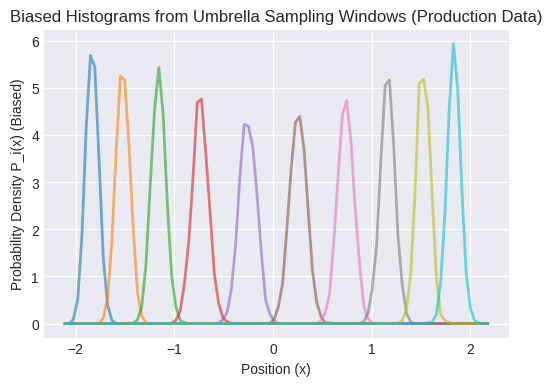

Observe the overlap between adjacent window histograms.
This overlap is crucial for WHAM to connect the windows.


In [ ]:
# --- Prepare Data for Custom WHAM ---

# Define bins for the global histogram
n_bins_global = 100
# Determine range from all production data
min_x_data = min(np.min(pos) for pos in all_positions_production if len(pos)>0) - 0.1
max_x_data = max(np.max(pos) for pos in all_positions_production if len(pos)>0) + 0.1
bin_edges_global = np.linspace(min_x_data, max_x_data, n_bins_global + 1)
bin_centers_global = 0.5 * (bin_edges_global[1:] + bin_edges_global[:-1])
print(f"Global histogram range: {min_x_data:.2f} to {max_x_data:.2f}")

# Calculate N_ij (counts per window i in global bin j)
N_ij = np.zeros((num_windows, n_bins_global), dtype=int)
for i in range(num_windows):
    if n_i[i] > 0: # Only histogram windows with data
        counts, _ = np.histogram(all_positions_production[i], bins=bin_edges_global)
        N_ij[i, :] = counts

# n_i (total samples per window) is already calculated

# Calculate reduced bias energy V_bias_i(x_j) / (kB*T)
# Bias energy = 0.5 * k_us * (x_j - x0_i)^2
reduced_bias_energies_ij = np.zeros((num_windows, n_bins_global))
beta = 1.0 / (k_B * temperature) # Inverse temperature
for i in range(num_windows):
    center_i = window_centers[i]
    V_bias_i_j = potential_bias_us(bin_centers_global, k_us=k_us, x0_us=center_i)
    reduced_bias_energies_ij[i, :] = beta * V_bias_i_j

print("Data prepared for custom WHAM:")
print(f"Counts matrix N_ij shape: {N_ij.shape}")
print(f"Total samples per window n_i shape: {n_i.shape}")
print(f"Reduced bias energies shape: {reduced_bias_energies_ij.shape}")

# --- Visualize Biased Histograms (Optional but Recommended) ---
# plt.figure(figsize=(12, 7))
plot_hist_success = False
for i in range(num_windows):
    if n_i[i] > 0: # Only plot windows with data
        # Normalize counts to probability density for plotting
        bin_width = bin_edges_global[1] - bin_edges_global[0]
        density = N_ij[i, :] / (n_i[i] * bin_width)
        plt.plot(bin_centers_global, density, label=f'Win {i+1} (x0={window_centers[i]:.1f})', alpha=0.6)
        plot_hist_success = True

if plot_hist_success:
    plt.title("Biased Histograms from Umbrella Sampling Windows (Production Data)")
    plt.xlabel("Position (x)")
    plt.ylabel("Probability Density P_i(x) (Biased)")
    # plt.legend() # Legend might be too crowded
    plt.grid(True)
    plt.show()
    print("Observe the overlap between adjacent window histograms.")
    print("This overlap is crucial for WHAM to connect the windows.")
else:
    print("Skipping histogram plot as no windows had sufficient production data.")

### WHAM Implementation

Here's a function to perform the iterative WHAM calculation.

In [ ]:
def run_wham(N_ij, n_i, reduced_bias_energies_ij, max_iter=10000, tolerance=1e-7, verbose=True):
    """
    Performs the iterative WHAM calculation.

    Args:
        N_ij (np.ndarray): Counts matrix (num_windows x num_bins).
        n_i (np.ndarray): Total samples per window (num_windows).
        reduced_bias_energies_ij (np.ndarray): Reduced bias energy V_bias/(kbT)
                                               for window i in bin j (num_windows x num_bins).
        max_iter (int): Maximum number of iterations.
        tolerance (float): Convergence tolerance for free energy offsets (f_i).
        verbose (bool): Print iteration info.

    Returns:
        tuple: (P_j, f_i) - Converged unbiased probability distribution (num_bins)
                 and window free energy offsets (num_windows), or (None, None) if failed.
                 P_j is normalized to sum to 1. f_i is in units of kT.
    """
    num_windows, num_bins = N_ij.shape
    beta = 1.0 # Assumes reduced_bias_energies are already beta*V

    # --- Initialization ---
    # Initial guess for free energy offsets (relative to window 0)
    f_i = np.zeros(num_windows)
    # Initial guess for unbiased probability (proportional to total counts in each bin)
    P_j = np.sum(N_ij, axis=0).astype(float)
    # Avoid division by zero if a bin has zero counts across all windows
    total_counts = np.sum(P_j)
    if total_counts < 1e-9:
        print("Error: Total counts across all bins are zero. Cannot initialize P_j.")
        return None, None
    P_j /= total_counts # Normalize initial guess

    if verbose:
        print("Starting WHAM iterations...")

    # --- Iteration Loop ---
    for iteration in range(max_iter):
        f_i_old = np.copy(f_i) # Store previous f_i for convergence check

        # --- Update P_j (Equation 1) ---
        # Calculate denominator: sum_k [ n_k * exp(f_k - V_bias_k(x_j)) ]
        exp_f_minus_V = np.exp(f_i[:, np.newaxis] - reduced_bias_energies_ij) # Shape (n_win, n_bins)
        denominator = np.sum(n_i[:, np.newaxis] * exp_f_minus_V, axis=0) # Shape (n_bins,)

        # Calculate numerator: sum_k N_k,j
        numerator = np.sum(N_ij, axis=0) # Shape (n_bins,)

        # Update P_j, handle division by zero for empty bins
        P_j_new = np.zeros_like(P_j)
        valid_bins = denominator > 1e-12 # Avoid division by tiny numbers
        P_j_new[valid_bins] = numerator[valid_bins] / denominator[valid_bins]

        # Normalize P_j to ensure it sums to 1
        P_j_sum = np.sum(P_j_new)
        if P_j_sum > 1e-9:
            P_j = P_j_new / P_j_sum
        else:
            # This case should ideally not happen if initialization was okay
            # but handle it just in case. Could indicate poor overlap or zero counts everywhere.
            print(f"Warning: Sum of P_j_new is near zero ({P_j_sum:.2e}) at iteration {iteration+1}. Using previous P_j.")
            # Keep the old P_j if the new one collapses to zero

        # --- Update f_i (Equation 2) ---
        # Calculate exp(-f_i) = sum_j [ P(x_j) * exp(-V_bias_i(x_j)) ]
        exp_minus_V = np.exp(-reduced_bias_energies_ij) # Shape (n_win, n_bins)
        sum_P_exp_minus_V = np.sum(P_j[np.newaxis, :] * exp_minus_V, axis=1) # Shape (n_win,)

        # Update f_i, handle log(0)
        # Set f_0 = 0 as reference
        f_i_new = np.zeros_like(f_i)
        valid_windows = sum_P_exp_minus_V > 1e-12
        # Calculate -log only for valid windows, others remain 0 (or handle as error)
        with warnings.catch_warnings():
             warnings.simplefilter("ignore", category=RuntimeWarning)
             f_i_new[valid_windows] = -np.log(sum_P_exp_minus_V[valid_windows])

        # Shift f_i so that f_0 = 0 (or another reference window if desired)
        f_i = f_i_new - f_i_new[0]

        # --- Check Convergence ---
        delta_f = np.max(np.abs(f_i - f_i_old))
        if verbose and (iteration % 100 == 0):
            print(f"  Iter {iteration+1}, Max Delta f_i: {delta_f:.4e}")
        if delta_f < tolerance:
            if verbose:
                print(f"WHAM converged after {iteration+1} iterations.")
            return P_j, f_i # Converged

    # If loop finishes without convergence
    print(f"Warning: WHAM did not converge within {max_iter} iterations. Max Delta f_i: {delta_f:.4e}")
    return P_j, f_i # Return last values

print("Custom WHAM function defined.")

Custom WHAM function defined.


### Running the WHAM Calculation

Execute the `run_wham` function with the prepared data.

In [ ]:
# --- Run Custom WHAM ---
# Ensure n_i has no zeros if filtering wasn't done earlier, WHAM needs >0 samples
if np.any(n_i <= 0):
    print("Error: Some windows have zero production samples. Cannot run WHAM.")
    P_j_wham = None
    f_i_wham = None
else:
    P_j_wham, f_i_wham = run_wham(
        N_ij, n_i, reduced_bias_energies_ij,
        max_iter=5000, tolerance=1e-5, verbose=True
    )

if P_j_wham is not None:
    print("\nConverged Free Energy Offsets (f_i / kT):")
    print(f_i_wham)
else:
    print("\nWHAM calculation failed or did not produce results.")

Starting WHAM iterations...
  Iter 1, Max Delta f_i: 4.6222e-01
  Iter 101, Max Delta f_i: 1.2822e-02
  Iter 201, Max Delta f_i: 8.9484e-03
  Iter 301, Max Delta f_i: 6.8624e-03
  Iter 401, Max Delta f_i: 5.2097e-03
  Iter 501, Max Delta f_i: 3.9703e-03
  Iter 601, Max Delta f_i: 3.0384e-03
  Iter 701, Max Delta f_i: 2.3322e-03
  Iter 801, Max Delta f_i: 1.7971e-03
  Iter 901, Max Delta f_i: 1.3872e-03
  Iter 1001, Max Delta f_i: 1.0713e-03
  Iter 1101, Max Delta f_i: 8.2759e-04
  Iter 1201, Max Delta f_i: 6.3952e-04
  Iter 1301, Max Delta f_i: 4.9439e-04
  Iter 1401, Max Delta f_i: 3.8239e-04
  Iter 1501, Max Delta f_i: 2.9598e-04
  Iter 1601, Max Delta f_i: 2.2929e-04
  Iter 1701, Max Delta f_i: 1.7783e-04
  Iter 1801, Max Delta f_i: 1.3812e-04
  Iter 1901, Max Delta f_i: 1.0746e-04
  Iter 2001, Max Delta f_i: 8.3789e-05
  Iter 2101, Max Delta f_i: 6.5504e-05
  Iter 2201, Max Delta f_i: 5.1372e-05
  Iter 2301, Max Delta f_i: 4.0444e-05
  Iter 2401, Max Delta f_i: 3.1986e-05
  Iter 25

### Calculating and Plotting the Reconstructed PMF

Calculate the PMF from the converged probability $P_j$ and plot it against the analytical potential.


PMF calculated. Min value shifted to 0.
PMF Barrier Height (Custom WHAM, approx): 4.09


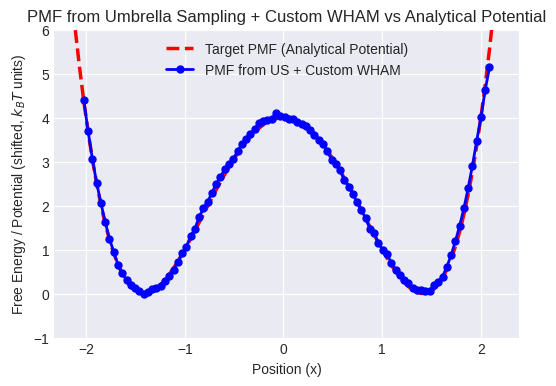

Compare the blue line (PMF from simulation) to the red dashed line (analytical potential).
Ideally, they should match closely, demonstrating successful reconstruction across the barrier.


In [ ]:
# --- Calculate PMF from WHAM Probability ---
pmf_wham = None
if P_j_wham is not None:
    # Calculate PMF = -kT * ln(P_j)
    # Avoid log(0) for bins with zero probability
    pmf_wham = np.full_like(P_j_wham, np.inf) # Initialize with infinity
    valid_bins_pmf = P_j_wham > 1e-12
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        pmf_wham[valid_bins_pmf] = -k_B * temperature * np.log(P_j_wham[valid_bins_pmf])

    # Shift PMF so its minimum is zero
    min_pmf_val = np.min(pmf_wham[np.isfinite(pmf_wham)])
    if np.isfinite(min_pmf_val):
        pmf_wham -= min_pmf_val
        print(f"\nPMF calculated. Min value shifted to 0.")
    else:
        print("\nWarning: Could not find finite minimum PMF value. PMF might be invalid.")
        pmf_wham = None # Mark as invalid


# --- Plot Reconstructed PMF ---

# Calculate analytical potential shifted to have minimum at 0
analytical_potential_dw_plot = potential_dw(bin_centers_global, a=a_dw, b=b_dw)
analytical_potential_dw_plot -= minima_val # Shift minimum to zero

# Plot analytical potential
plt.plot(bin_centers_global, analytical_potential_dw_plot, 'r--', linewidth=2.5, label="Target PMF (Analytical Potential)")

# Plot custom WHAM PMF if available
if pmf_wham is not None:
    plt.plot(bin_centers_global, pmf_wham, 'bo-', markersize=5, label="PMF from US + Custom WHAM")
    # Estimate barrier height from calculated PMF
    barrier_region_mask = (bin_centers_global > -minima_pos * 0.5) & (bin_centers_global < minima_pos * 0.5)
    if np.any(barrier_region_mask & np.isfinite(pmf_wham)):
         pmf_barrier_max = np.max(pmf_wham[barrier_region_mask & np.isfinite(pmf_wham)])
         print(f"PMF Barrier Height (Custom WHAM, approx): {pmf_barrier_max:.2f}")
    else:
         print("Could not estimate PMF barrier height (no finite points in barrier region).")
else:
    plt.text(0, barrier_height / 2, "PMF Calculation Failed or Skipped.", ha='center', color='red', fontsize=12)


plt.xlabel("Position (x)")
plt.ylabel("Free Energy / Potential (shifted, $k_B T$ units)")
plt.title("PMF from Umbrella Sampling + Custom WHAM vs Analytical Potential")
plt.ylim(-1, barrier_height * 1.5 if barrier_height > 0 else 5) # Adjust ylim
plt.legend()
plt.grid(True)
plt.show()

print("Compare the blue line (PMF from simulation) to the red dashed line (analytical potential).")
print("Ideally, they should match closely, demonstrating successful reconstruction across the barrier.")

### Convergence of PMF vs. Production Length

After reconstructing the PMF with WHAM on the full dataset, verify convergence by running WHAM on increasing subsets of the umbrella trajectories. We vary the number of frames per window ($M$ = 100, 200, … up to the full length) and track:

- The free-energy difference between the two minima (`ΔG_minima`)
- The free-energy barrier height (`ΔG_barrier`)

**Important points to note**:

- **Physically relevant points**: In a real-world scenario, you would carefully choose the points for your convergence analysis based on the specific system you are studying and the quantities you want to compute. It could be the free energy difference between two states, the barrier height between them, or other properties of interest.

- **Assumptions**: In this example, we've assumed knowledge of the minima positions and barrier position for the double-well potential. In practice, you might need to use other techniques to find these points beforehand.
Convergence indicators: We're still tracking the deltaG_minima and deltaG_barrier_min1 values to assess convergence. You might need to monitor other quantities depending on your system and requirements.

Plotting these as a function of $M$ shows whether the PMF has stabilized.

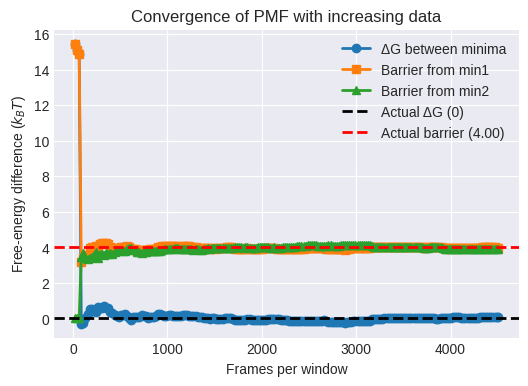

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Setup ---
max_frames = min(len(p) for p in all_positions_production)
nsteps = 200
step_size  = max(1, max_frames // nsteps)
steps      = list(range(step_size, max_frames+1, step_size))
if steps[-1] != max_frames:
    steps.append(max_frames)

# Precompute target indices
min1_pos    = -np.sqrt(b_dw / (2 * a_dw))
min2_pos    =  np.sqrt(b_dw / (2 * a_dw))
barrier_pos =  0.0

idx_min1    = np.argmin(np.abs(bin_centers_global - min1_pos))
idx_min2    = np.argmin(np.abs(bin_centers_global - min2_pos))
idx_barrier = np.argmin(np.abs(bin_centers_global - barrier_pos))

# Containers
deltaG_minima       = []
deltaG_barrier_min1 = []
deltaG_barrier_min2 = []

# --- Convergence loop ---
for M in steps:
    # build counts up to frame M for each window
    N_ij_M = np.array([
        np.histogram(pos[:M], bins=bin_edges_global)[0]
        for pos in all_positions_production
    ])
    n_i_M = N_ij_M.sum(axis=1)

    # run WHAM
    P_j_M, _ = run_wham(N_ij_M, n_i_M, reduced_bias_energies_ij,
                        max_iter=10000, tolerance=1e-4,verbose=False)

    # compute PMF
    pmf_M = -k_B * temperature * np.log(P_j_M + 1e-18)

    # record free‐energy differences
    deltaG_minima.append       (pmf_M[idx_min2]    - pmf_M[idx_min1])
    deltaG_barrier_min1.append (pmf_M[idx_barrier] - pmf_M[idx_min1])
    deltaG_barrier_min2.append (pmf_M[idx_barrier] - pmf_M[idx_min2])

# --- Plot ---
plt.figure()
plt.plot(steps, deltaG_minima,       'o-', label='ΔG between minima')
plt.plot(steps, deltaG_barrier_min1, 's-', label='Barrier from min1')
plt.plot(steps, deltaG_barrier_min2, '^-', label='Barrier from min2')

plt.axhline(0, linestyle='--', color='k', label='Actual ΔG (0)')
plt.axhline(barrier_height, linestyle='--', color='r',
            label=f'Actual barrier ({barrier_height:.2f})')

plt.xlabel('Frames per window')
plt.ylabel('Free‐energy difference ($k_B T$)')
plt.title('Convergence of PMF with increasing data')
plt.legend()
plt.grid(True)
plt.show()


---
End of Module 5. We have successfully implemented Umbrella Sampling and used a custom WHAM implementation to reconstruct the PMF:

* **Umbrella Sampling (US):** Used harmonic bias potentials ("umbrellas") to force sampling across the double-well potential.
* **Data Processing:** Handled burn-in and prepared histogram counts and bias energies.
* **Custom WHAM:** Implemented the iterative WHAM equations to combine data from all windows and calculate the unbiased probability distribution.
* **PMF Reconstruction:** Calculated the unbiased PMF from the WHAM probability and visualized how it reproduces the true potential energy landscape, overcoming the sampling limitations of standard MD.

In Module 6, we will explore another powerful enhanced sampling technique: **Metadynamics**.